# $SAR_{10g}$ Hotspot Value Prediction Model

* **Author**: Shayan Dodge 
* **Email**: dodgeshayan@gmail.com

This notebook demonstrates the complete pipeline for predicting Specific Absorption Rate (SAR) hotspot values using deep learning. It includes the following steps:
1. *Data Preprocessing*: Loading and processing SAR data and images, including resizing images and normalizing inputs.
2. *Model Architecture*: Building a multi-input model that combines Convolutional Neural Networks (CNNs) for image processing and fully connected layers for frequency input.
3. *Model Training*: Compiling and training the model using the training dataset, with early stopping to prevent overfitting.
4. *Performance Evaluation*: Evaluating the model’s performance using Mean Absolute Error (MAE) and Mean Squared Error (MSE) metrics on the test dataset.

By the end of this notebook, you will have a trained model capable of predicting SAR values based on images and frequency inputs, along with performance metrics to assess its accuracy.


## 1. Image and Metadata Processing for Model Training

* This section demonstrates the process of loading and preprocessing images along with their associated metadata (SAR values and frequencies). 

* The data is then split into training, validation, and test sets to prepare for model training.

In [1]:
import os
import json
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image

# Enable eager execution for TensorFlow
# This is important to enable immediate evaluation of operations, useful for debugging.
tf.compat.v1.enable_eager_execution()

# Define paths to your data
# Set the paths to the image folder and the CSV file containing metadata.
image_folder = 'normal'  # Path to folder containing images
csv_file = 'normal/SAR_MaxValues.csv'  # Path to CSV file containing image metadata

# Desired image shape after resizing
# The target size defines the shape that each image will be resized to before being fed into the model.
IMG_SHAPE = (56, 106)
target_size = (56, 106)

# Load the CSV file into a Pandas DataFrame
# Pandas is used to load and manipulate the CSV data.
df = pd.read_csv(csv_file)

# Get the minimum value of the SAR column for transformation
min_value = df['sar'].min()

# Apply transformation to SAR values and calculate the mean and standard deviation
# Scaling SAR values and calculating the statistics helps normalize the target values.
df['sar'] = (1/min_value)*(df['sar'])  # Scale SAR values
log_sar_values = df['sar'].values
sar_mean = np.mean(log_sar_values)  # Calculate mean of the SAR values
sar_std = np.std(log_sar_values)    # Calculate standard deviation of the SAR values

# Function to load images and their corresponding bounding boxes
# This function reads each image from the disk, resizes it, and collects the corresponding labels and targets.
def load_images(df, image_folder, target_size=IMG_SHAPE):
    images = []  # List to store image arrays
    labels = []  # List to store labels (frequency)
    targets = [] # List to store targets (SAR values)
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        # Construct the image file path based on the row data
        image_name = row['z']
        image_path = os.path.join(image_folder, str(int(row['z'])) + '_' + str(int(row['f'])) + '.png')

        # Load and resize the image
        img = Image.open(image_path)  # Open the image
        original_width, original_height = img.size  # Get original image size
        img = img.resize(target_size)  # Resize image to target size
        img_array = np.array(img)  # Convert resized image to numpy array       
        # Extract location of spot and frequency
        x = round(row['x'] * target_size[0] / original_width)  # Rescale x-coordinate
        y = round(row['y'] * target_size[1] / original_height)  # Rescale y-coordinate
        f = row['f']  # Extract frequency value
        sar = row['sar']  # Extract SAR value
        label_array = np.array((f))  # Convert frequency to array (single value)
        targets_array = np.array((sar))  # Convert SAR to array (single value)
        
        # Append image, label, and target to their respective lists
        images.append(img_array)
        labels.append(label_array)
        targets.append(targets_array)   
    
    return images, labels, targets

# Load images and their corresponding labels
# Call the load_images function to load and resize images, as well as get the corresponding labels and targets.
images, labels, targets = load_images(df, image_folder, target_size)

# Convert lists of images, labels, and targets to numpy arrays
# Converting lists to numpy arrays is required to feed data into TensorFlow models.
images_np = np.array(images)
labels_np = np.array(labels)
targets_np = np.array(targets)

# Preprocessing function to normalize images and prepare data
# This function normalizes the images and prepares the data by ensuring the images are float32 and scaled.
def preprocess(image, numerical, target):
    image = tf.cast(image, tf.float32)/255  # Normalize image values to the range [0, 1]
    return (image, numerical), target  # Return the image and frequency as inputs and the SAR value as target

# Create TensorFlow Dataset
# The dataset is created from the numpy arrays containing images, labels, and targets.
dataset = tf.data.Dataset.from_tensor_slices((images_np, labels_np, targets))

# Set buffer size for shuffling the dataset
buffer_size = 2000  # Adjust the buffer size as needed
seed = 42  # Set the seed for reproducibility

# Shuffle the dataset before splitting
shuffled_dataset = dataset.shuffle(buffer_size, seed=seed)

# Shuffle and split the dataset into training, validation, and test sets
dataset_size = len(images_np)  # Get the total number of samples
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = int(0.15 * dataset_size)  # 15% for testing

# Split the dataset into training, validation, and test sets
train_dataset = shuffled_dataset.take(train_size)

remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(test_size)

# Preprocess, batch, and shuffle the datasets
batch_size = 32  # Set the batch size for training

# Apply preprocessing, shuffling, and batching to the datasets
train_dataset = train_dataset.map(preprocess).shuffle(buffer_size=train_size).batch(batch_size)
val_dataset = val_dataset.map(preprocess).batch(batch_size)  # No need to shuffle validation/test sets
test_dataset = test_dataset.map(preprocess).batch(batch_size)

# Print dataset sizes
# Output the sizes of the datasets for reference.
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")



Train dataset size: 946
Validation dataset size: 202
Test dataset size: 202


## 2. Visualizing Image Batches with Metadata

* This section visualizes a batch of images from the training dataset, displaying each image along with its associated frequency (f) and standardized SAR value.


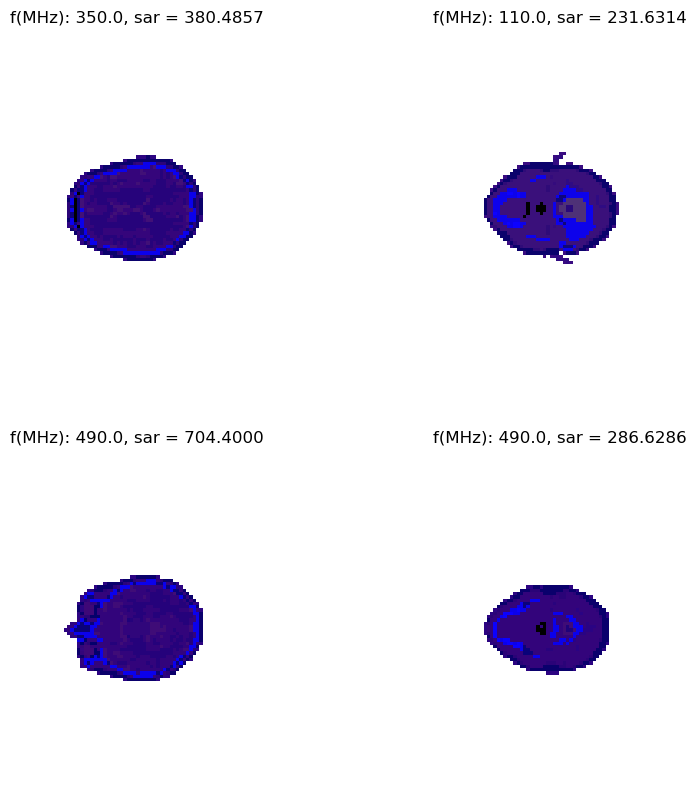

In [2]:
import matplotlib.pyplot as plt

# Iterate through the dataset and extract one batch
for (images, labels), targets in train_dataset.take(1):
    # images is a batch of images, labels contain the corresponding labels, targets are additional targets

    # Convert the tensor to a numpy array for plotting
    image_batch = images.numpy()
    f = labels.numpy()
    sar = targets.numpy()

    # Visualize a few images along with their labels and targets
    plt.figure(figsize=(10, 10))
    for i in range(4):  # Display the first 4 images
        plt.subplot(2, 2, i + 1)
        plt.imshow(image_batch[i])
        plt.title(f"f(MHz): {f[i]:.1f}, sar = {sar[i]:.4f}")
        plt.axis('off')
    plt.show()

## 3. Creating Multi-Input Convolutional Neural Network

* The model processes two types of input:
    1. *Image Input*: A convolutional neural network (CNN) extracts features from images.
    2. *Frequency Input*: A dense network processes a single scalar frequency value.

* The outputs from both branches are concatenated and passed through dense layers to predict the Specific Absorption Rate (SAR), ensuring accuracy in hotspot localization. 

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Image input
# Define the input layer for images. The input shape is assumed to be 71x71 pixels with 3 channels (RGB).
# IMG_SHAPE should be a tuple representing the image dimensions (height, width).
image_input = Input(shape=(IMG_SHAPE[1], IMG_SHAPE[0], 3))

# CNN Layers for Image Processing
# The Convolutional layers will extract features from the images.
# 1. First Convolutional Layer: 32 filters with a 3x3 kernel, ReLU activation.
x = Conv2D(32, (3, 3), activation='relu')(image_input)
# 2. MaxPooling Layer: Reduces the spatial dimensions by a factor of 2.
x = MaxPooling2D((2, 2))(x)
# 3. Second Convolutional Layer: 64 filters, 3x3 kernel, ReLU activation.
x = Conv2D(64, (3, 3), activation='relu')(x)
# 4. MaxPooling Layer
x = MaxPooling2D((2, 2))(x)
# 5. Third Convolutional Layer: 128 filters, 3x3 kernel, ReLU activation.
x = Conv2D(128, (3, 3), activation='relu')(x)
# 6. MaxPooling Layer
x = MaxPooling2D((2, 2))(x)

# Flatten the output of the convolutional layers to feed into fully connected layers
x = Flatten()(x)

# Fully connected layer with 128 units and ReLU activation for additional feature learning
x = Dense(128, activation='relu')(x)

# Frequency Input
# Define the input layer for the frequency value (a single scalar).
freq_input = Input(shape=(1,))  # A single scalar representing the frequency

# Dense Layer for Frequency
# Use a Dense layer to process the frequency input.
f = Dense(64, activation='relu')(freq_input)

# Concatenate Image and Frequency Features
# Combine the features extracted from the image (x) and the frequency input (f) into one vector.
combined = Concatenate()([x, f])

# Dense Layers After Concatenation
# These layers will further process the combined features before outputting the predicted SAR.
output = Dense(128, activation='relu')(combined)  # First dense layer with 128 units
output = Dense(64, activation='relu')(output)    # Second dense layer with 64 units

# Output Layer for SAR Prediction
# The final output layer predicts the SAR value (a continuous scalar).
# We do not apply an activation function here, allowing the output to take any real value.
sar_output = Dense(1)(output)

# Define the Model
# We specify the model by passing the image and frequency inputs and the SAR output.
model = Model(inputs=[image_input, freq_input], outputs=sar_output)

# Compile the Model
# The Adam optimizer is used with a learning rate of 1e-3, and Huber loss is used for training.
# Huber loss is useful when dealing with outliers in regression problems.
model.compile(optimizer=Adam(learning_rate=1E-3), loss=tf.keras.losses.Huber(delta=1000))

# Display the Model Summary
# This will print out a summary of the model, including the layers, the number of parameters, and the output shapes.
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 106, 56, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 104, 54, 32)  896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 52, 27, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 25, 64)   18496       ['max_pooling2d[0][0]']      

## 4. Model Training with Early Stopping

* This section trains a deep learning model using early stopping to prevent overfitting. 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


# Early stopping for the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience = 100 , restore_best_weights=True)

# Fit the model
model.fit(train_dataset, validation_data=val_dataset,batch_size=batch_size, epochs=2000, callbacks=[early_stopping]) 

Epoch 1/2000
30/30 [==============================] - 2s 60ms/step - loss: 47016.9141 - val_loss: 40460.8281
Epoch 2/2000
30/30 [==============================] - 2s 58ms/step - loss: 34787.9492 - val_loss: 31243.7871
Epoch 3/2000
30/30 [==============================] - 2s 59ms/step - loss: 34551.0586 - val_loss: 25932.5625
Epoch 4/2000
30/30 [==============================] - 2s 59ms/step - loss: 29279.6855 - val_loss: 32770.3555
Epoch 5/2000
30/30 [==============================] - 2s 70ms/step - loss: 29067.1367 - val_loss: 42644.4062
Epoch 6/2000
30/30 [==============================] - 2s 59ms/step - loss: 27431.3496 - val_loss: 30946.7812
Epoch 7/2000
30/30 [==============================] - 2s 59ms/step - loss: 30159.7656 - val_loss: 26156.1172
Epoch 8/2000
30/30 [==============================] - 2s 57ms/step - loss: 31544.6426 - val_loss: 26785.9707
Epoch 9/2000
30/30 [==============================] - 2s 58ms/step - loss: 29265.6211 - val_loss: 35341.5742
Epoch 10/2000
30/30

## 5. Saving the Trained Model

* This section demonstrates how to save the trained deep learning model to an HDF5 file format (`SAR_model.h5`).


In [5]:
# # Save the model to an HDF5 file
# model.save('SAR_model.h5')  # Save the model to a file

## 6. Loading the Saved Model

* This section demonstrates how to load a previously saved deep learning model from an HDF5 file (`SAR_model.h5`).


In [6]:
# from tensorflow.keras.models import load_model

# # Load the model (when needed)
# model = load_model('SAR_model.h5')  # Load the model from the file

## 7. Evaluation of Model Performance: MAE and MSE



In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and actual_sar have already been computed
# Unbatch the test dataset and gather images, numerical data, and targets as lists
unbatched_data = list(test_dataset.unbatch().take(test_size).as_numpy_iterator())

test_images_tf = [item[0][0] for item in unbatched_data]  # Extract image part
test_numerical_tf = [item[0][1] for item in unbatched_data]  # Extract numerical part
test_targets_tf = [item[1] for item in unbatched_data]  # Extract target part

# Convert lists to TensorFlow tensors (stack them)
test_images_tf = tf.stack(test_images_tf)  # Shape should be (batch_size, height, width, channels)
test_numerical_tf = tf.stack(test_numerical_tf)  # Shape should be (batch_size, num_features)
test_targets_tf = tf.stack(test_targets_tf)  # Shape should be (batch_size, target_size)

# Predict using the trained model by passing the stacked tensors
predictions = model.predict([test_images_tf, test_numerical_tf])

# Ensure that both actual_sar and predicted_sar are of the same type (float32)
actual_sar = tf.cast(test_targets_tf, dtype=tf.float32)  # Casting the actual SAR values
predicted_sar = tf.cast(predictions, dtype=tf.float32)   # Casting the predicted SAR values

# Compute MAE and MSE using sklearn methods
mae_selected = mean_absolute_error(actual_sar, predicted_sar)
mse_selected = mean_squared_error(actual_sar, predicted_sar)

# Print MAE and MSE for the selected images
print(f"MAE : {mae_selected}")
print(f"MSE : {mse_selected}")


7/7 [==============================] - 1s 46ms/step
MAE : 21.024658203125
MSE : 848.7515258789062


## 8. Comparison of Predicted vs Actual $SAR_{10g}$ Values

* This plot visualizes the comparison between the predicted and actual $SAR_{10g}$ values. The scatter plot shows the predicted values against the actual values, with an ideal line representing perfect predictions.


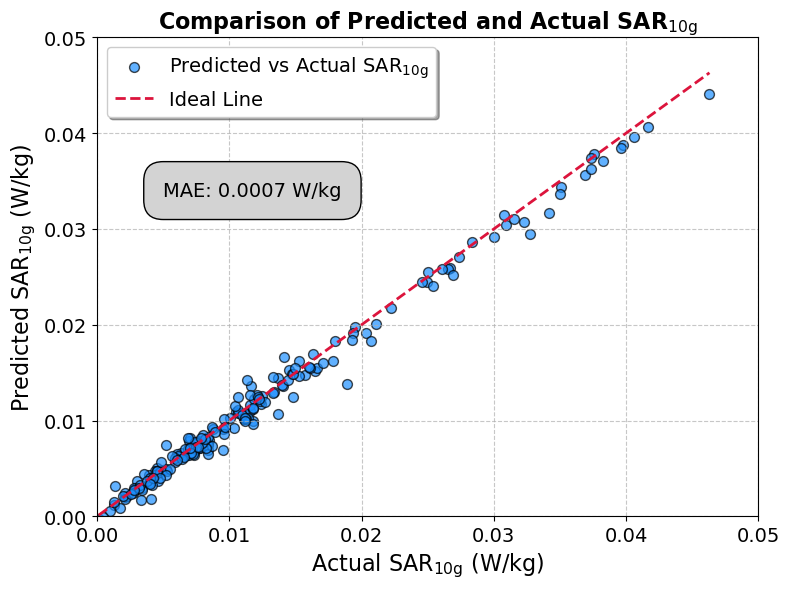

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Create a scatter plot of predicted vs actual SAR values
plt.figure(figsize=(8, 6))
plt.scatter(actual_sar * min_value, predicted_sar * min_value, color='dodgerblue', 
            label=r'Predicted vs Actual SAR$_{\mathrm{10g}}$', alpha=0.7, edgecolor='black', s=50)

# Plot the ideal line
plt.plot([min(actual_sar) * min_value, max(actual_sar) * min_value], 
         [min(actual_sar) * min_value, max(actual_sar) * min_value], 
         color='crimson', linestyle='--', linewidth=2, label='Ideal Line')

# Set labels and title
plt.xlabel(r'Actual SAR$_{\mathrm{10g}}$ (W/kg)', fontsize=16)
plt.ylabel(r'Predicted SAR$_{\mathrm{10g}}$ (W/kg)', fontsize=16)
plt.title(r'Comparison of Predicted and Actual SAR$_{\mathrm{10g}}$', fontsize=16, fontweight='bold')

# Create a text box to display MAE and MSE
textstr = f'MAE: {mae_selected * min_value:.4f} W/kg'
# textstr = f'MAE: {mae_selected / 10**5:.2e}\nMSE: {math.sqrt(mse_selected) / 10**5:.2e}'
# Place a text box in the upper left in axes coordinates
plt.gca().text(0.1, 0.7, textstr, transform=plt.gca().transAxes, fontsize=14,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=1.', edgecolor='black', facecolor='lightgrey'))

# Enhance the plot's legend
plt.legend(fontsize=14, loc='upper left', shadow=True)

# Improve grid visibility
plt.grid(True, linestyle='--', alpha=0.7)

# Set limits for better clarity
plt.xlim(0, 0.05) # np.max(actual_sar * min_value) * 1.05
plt.ylim(0, 0.05)

# Increase tick size
plt.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=14)  # Minor ticks (if you have any)

# Show the plot
plt.tight_layout()
plt.show()
